# Image segmentation
## 1.import module

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow_examples.models.pix2pix.pix2pix import upsample
from tensorflow_examples.models.pix2pix.pix2pix import downsample

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

from LoadData import Lab2DataLoader

## 2.load data and test data

In [2]:
train_img, test_img, color_codes = Lab2DataLoader().loadData()
INPUT_SHAPE = train_img['image'].shape[1:]
TRAIN_LENGTH = train_img['image'].shape[0]
TEST_LENGTH = test_img['image'].shape[0]
CLASSES = color_codes.shape[0]

cmap = colors.ListedColormap(color_codes / 255.0, "color_codes")
norm = colors.BoundaryNorm(np.arange(0, CLASSES), cmap.N)

print(f'dataset shape: train {train_img["image"].shape} test {test_img["image"].shape}')

dataset shape: train (2975, 128, 256, 3) test (500, 128, 256, 3)


### 2.1 buile tensorflow dataset

In [3]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

### 2.2 Augment random horizontal flip

In [4]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
def load_image(dataset):
    input_image = tf.image.resize(dataset['image'],INPUT_SHAPE[:-1])
    input_mask = tf.image.resize(dataset['mask'],INPUT_SHAPE[:-1])
    input_image, input_mask = normalize(input_image), input_mask

    return input_image, input_mask

In [6]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_img)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = (
    train_dataset
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices(test_img)
test_dataset = (
    test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
)

print(train_dataset)

<PrefetchDataset shapes: ((None, 128, 256, 3), (None, 128, 256, 1)), types: (tf.float32, tf.float32)>


### 2.3 display mask image

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap=cmap)
            # plt.colorbar()
        plt.axis('off')
    plt.show()

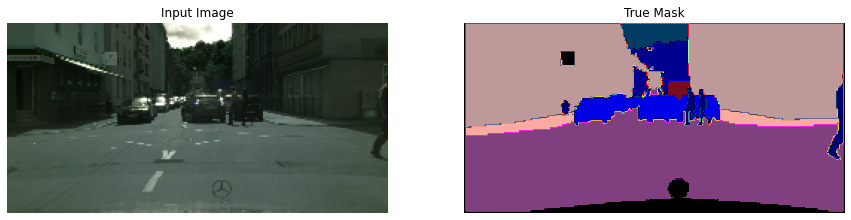

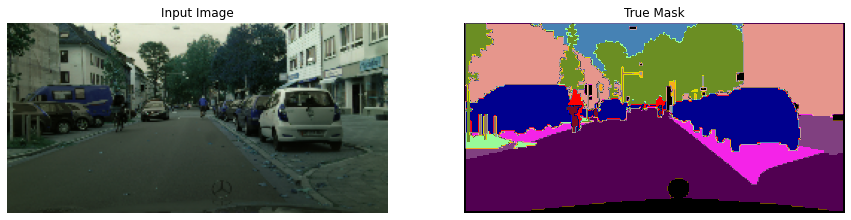

In [9]:
for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## 3.Define the model
[U-Net](https://arxiv.org/abs/1505.04597) encoder (downsampler) and decoder (upsampler)

In [10]:
def unet_model():
    assert INPUT_SHAPE == (128, 256, 3)
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    down_stack = [
        downsample(64, 4, apply_norm=False),  # (batch_size, 64, 128, 64)
        downsample(128, 4),  # (batch_size, 32, 64, 128)
        downsample(256, 4),  # (batch_size, 16, 32, 256)
        downsample(512, 4),  # (batch_size, 8, 16, 512)
        downsample(1024, 4),  # (batch_size, 4, 8, 1024)
        downsample(1024, 4),  # (batch_size, 2, 4, 1024)
        downsample(1024, 4),  # (batch_size, 1, 2, 1024)
    ]

    up_stack = [
        upsample(1024, 4, apply_dropout=True),  # (batch_size, 2, 4, 2048)
        upsample(1024, 4, apply_dropout=True),  # (batch_size, 4, 8, 2048)
        upsample(512, 4),  # (batch_size, 8, 16, 1024)
        upsample(256, 4),  # (batch_size, 16, 32, 512)
        upsample(128, 4),  # (batch_size, 32, 64, 256)
        upsample(64, 4),  # (batch_size, 64, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(CLASSES, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 128, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
model = unet_model()

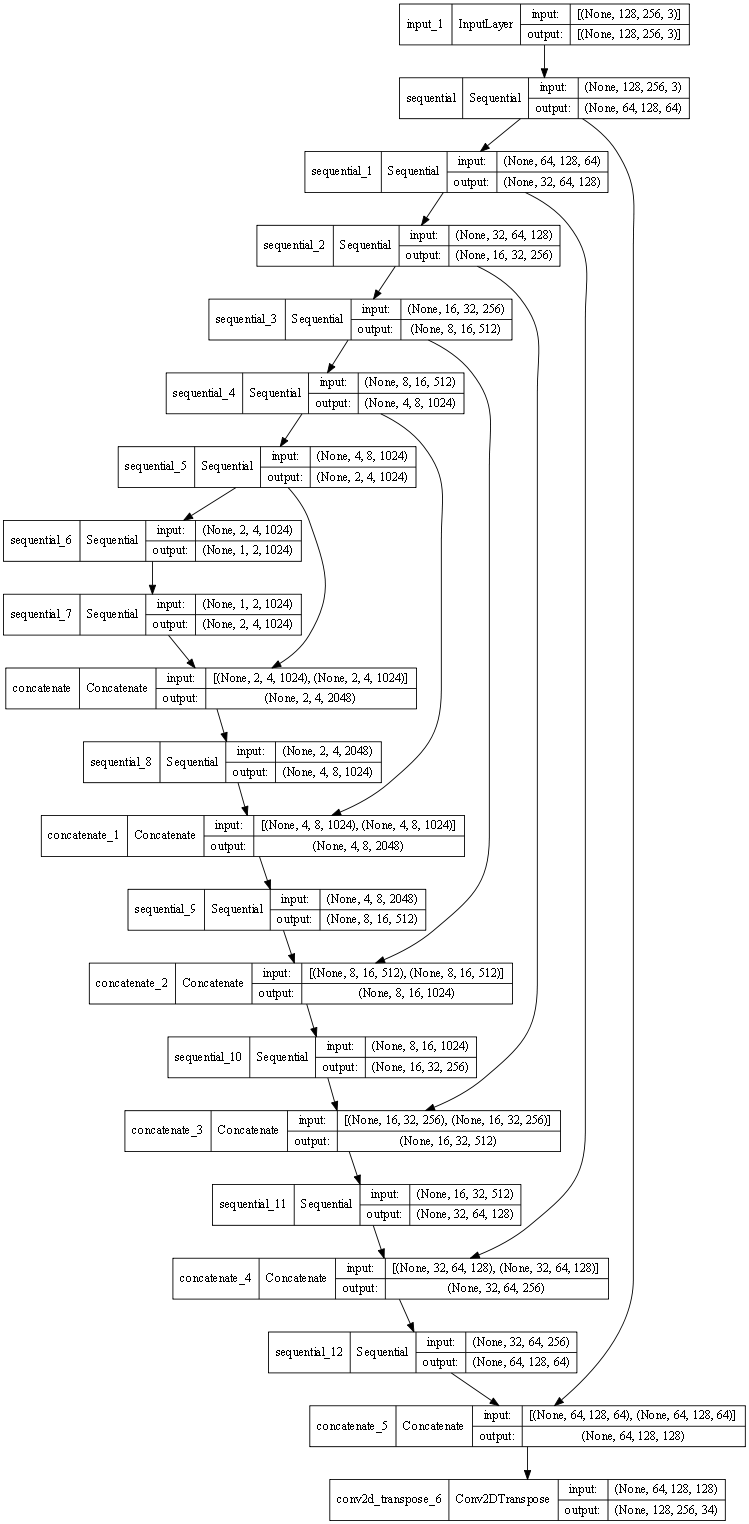

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
# model.summary()

## 4.Train the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [16]:
def show_predictions(dataset=None,random = True, num=1):
    if random:
        dataset = dataset.shuffle(BUFFER_SIZE)
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

### Test show prediction
display prediction in training

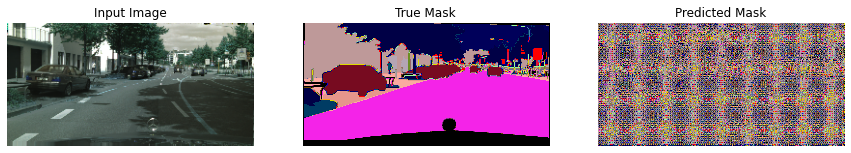

In [17]:
show_predictions(dataset=test_dataset)

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(dataset=test_dataset,random=False)
        show_predictions(dataset=test_dataset)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

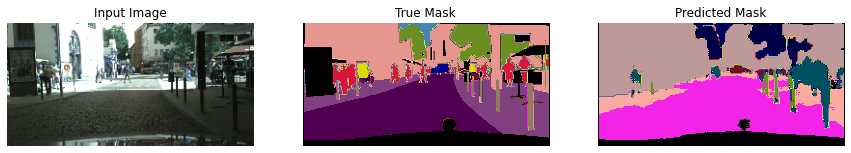

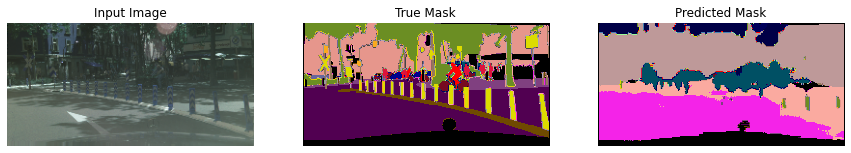


Sample Prediction after epoch 20

47/47 [==============================] - 10s 219ms/step - loss: 1.9112 - accuracy: 0.8385 - val_loss: 1.9686 - val_accuracy: 0.7931


In [19]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//VAL_SUBSPLITS
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          # validation_steps=VALIDATION_STEPS,
                          callbacks=[DisplayCallback()])

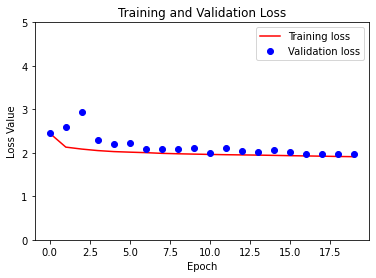

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 5])
plt.legend()
plt.show()

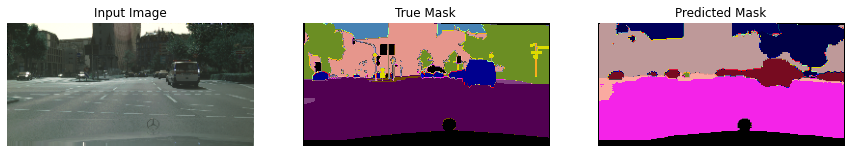

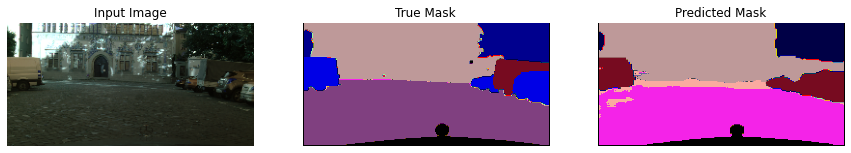

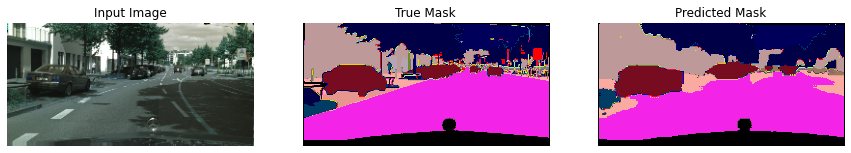

In [22]:
show_predictions(test_dataset, num=3)

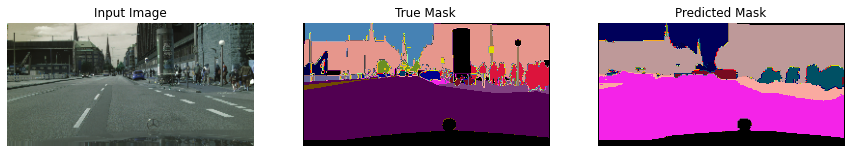

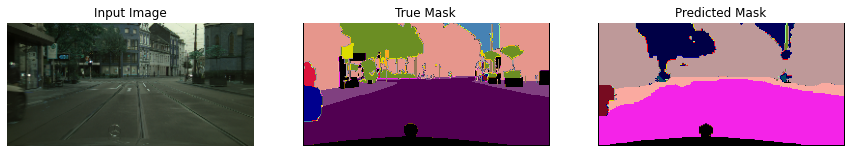

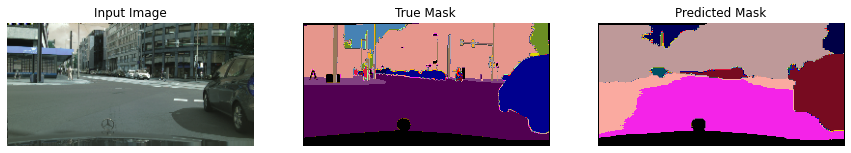

In [24]:
show_predictions(train_dataset, num=3)